# Test 6
Fuck me i hate my life

## General Shit

In [2]:
import numpy as np
import os.path as path
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, ConfusionMatrixDisplay
import pandas as pd
import monke_features as mf
import monke_classify as mc
import monke_io as mio
import matplotlib.pyplot as plt
import itertools

In [3]:
# KOI
names_koi = ["koi_apr11", "koi_apr17", "koi_apr25", "koi_apr25_3", "koi_apr25_4", "koi_apr25_5", "koi_apr25_6"]

pose_data_koi = mio.read_poses(names_koi)
tremors_raw = mio.read_tremors_multi(names_koi)
labels_koi = {}

for name in tremors_raw:
    labels_koi[name] = mf.generate_labelled_frames(pose_data_koi[name], tremors_raw[name])

# BOBA
names_boba = ["boba_apr11", "boba_apr21", "boba_apr21_2", "boba_apr25", "boba_apr25_2"]

pose_data_boba = mio.read_poses(names_boba)
tremors_raw = mio.read_tremors_multi(names_boba)
labels_boba = {}

for name in tremors_raw:
    labels_boba[name] = mf.generate_labelled_frames(pose_data_boba[name], tremors_raw[name])

# BANDUNG
names_bandung = ["bandung_mar27", "bandung_mar27_2", "bandung_mar27_3", "bandung_may19_2"]

pose_data_bandung = mio.read_poses(names_bandung)
tremors_raw = mio.read_tremors_multi(names_bandung)
labels_bandung = {}

for name in tremors_raw:
    labels_bandung[name] = mf.generate_labelled_frames(pose_data_bandung[name], tremors_raw[name])

# HORLICKS
names_horlicks = ["horlicks_apr12", "horlicks_may2", "horlicks_jun16"]

pose_data_horlicks = mio.read_poses(names_horlicks)
tremors_raw = mio.read_tremors_multi(names_horlicks)
labels_horlicks = {}

for name in tremors_raw:
    labels_horlicks[name] = mf.generate_labelled_frames(pose_data_horlicks[name], tremors_raw[name])
    
# BRIYANI
names_briyani = ["briyani_apr12", "briyani_may19", "briyani_jun16"]

pose_data_briyani = mio.read_poses(names_briyani)
tremors_raw = mio.read_tremors_multi(names_briyani)
labels_briyani = {}

for name in tremors_raw:
    labels_briyani[name] = mf.generate_labelled_frames(pose_data_briyani[name], tremors_raw[name])
    
# TUTU KUEH
names_tutukueh = ["tutukueh_apr21", "tutukueh_may2", "tutukueh_jun15"]

pose_data_tutukueh = mio.read_poses(names_tutukueh)
tremors_raw = mio.read_tremors_multi(names_tutukueh)
labels_tutukueh = {}

for name in tremors_raw:
    labels_tutukueh[name] = mf.generate_labelled_frames(pose_data_tutukueh[name], tremors_raw[name])

# ALL
names_all = {"koi":names_koi, "boba":names_boba, "bandung":names_bandung, 
             "horlicks":names_horlicks, "briyani":names_briyani, "tutukueh":names_tutukueh}
pose_data_all = {"koi":pose_data_koi, "boba":pose_data_boba, "bandung":pose_data_bandung, 
             "horlicks":pose_data_horlicks, "briyani":pose_data_briyani, "tutukueh":pose_data_tutukueh}
labels_all = {"koi":labels_koi, "boba":labels_boba, "bandung":labels_bandung, 
             "horlicks":labels_horlicks, "briyani":labels_briyani, "tutukueh":labels_tutukueh}

## Test 6A: Video to Video

**Aim**: Check how classifiers predict a video's tremors when trained on another video or the same video.

**Feature Tested**: Directional Change

**Noise Correction**: 0.1 threshold and 10 sliding window

**Weights**: None

**Class Balance**: Balanced

_Training Data (Individually)_
* Koi, April 11 (80%)
* Koi, April 17 (80%)
* Koi, April 25 (80%)
* Koi, April 25 (3) (80%)
* Koi, April 25 (4) (80%)
* Koi, April 25 (5) (80%)
* Koi, April 25 (6) (80%)
* Boba, April 11 (80%)
* Boba, April 21 (80%)
* Boba, April 21 (2) (80%)
* Boba, April 25 (80%)
* Boba, April 25 (2) (80%)

_Testing Data_
* Koi, April 11 (20%)
* Koi, April 17 (20%)
* Koi, April 25 (20%)
* Koi, April 25 (3) (20%)
* Koi, April 25 (4) (20%)
* Koi, April 25 (5) (20%)
* Koi, April 25 (6) (20%)
* Boba, April 11 (20%)
* Boba, April 21 (20%)
* Boba, April 21 (2) (20%)
* Boba, April 25 (20%)
* Boba, April 25 (2) (20%)

In [5]:
process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)

processed_data, processed_labels = process_data(pose_data_all, labels_all, process)
training_data, testing_data, training_labels, testing_labels = prep_multi_train_test_data(processed_data, processed_labels, names_all)

results_6a = {}

for name in training_data:
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(training_data[name], training_labels[name])

    results_6a[name] = {}

    for testing_name in testing_data:
        results_6a[name][testing_name] = test_classify(clf, testing_data[testing_name], testing_labels[testing_name])

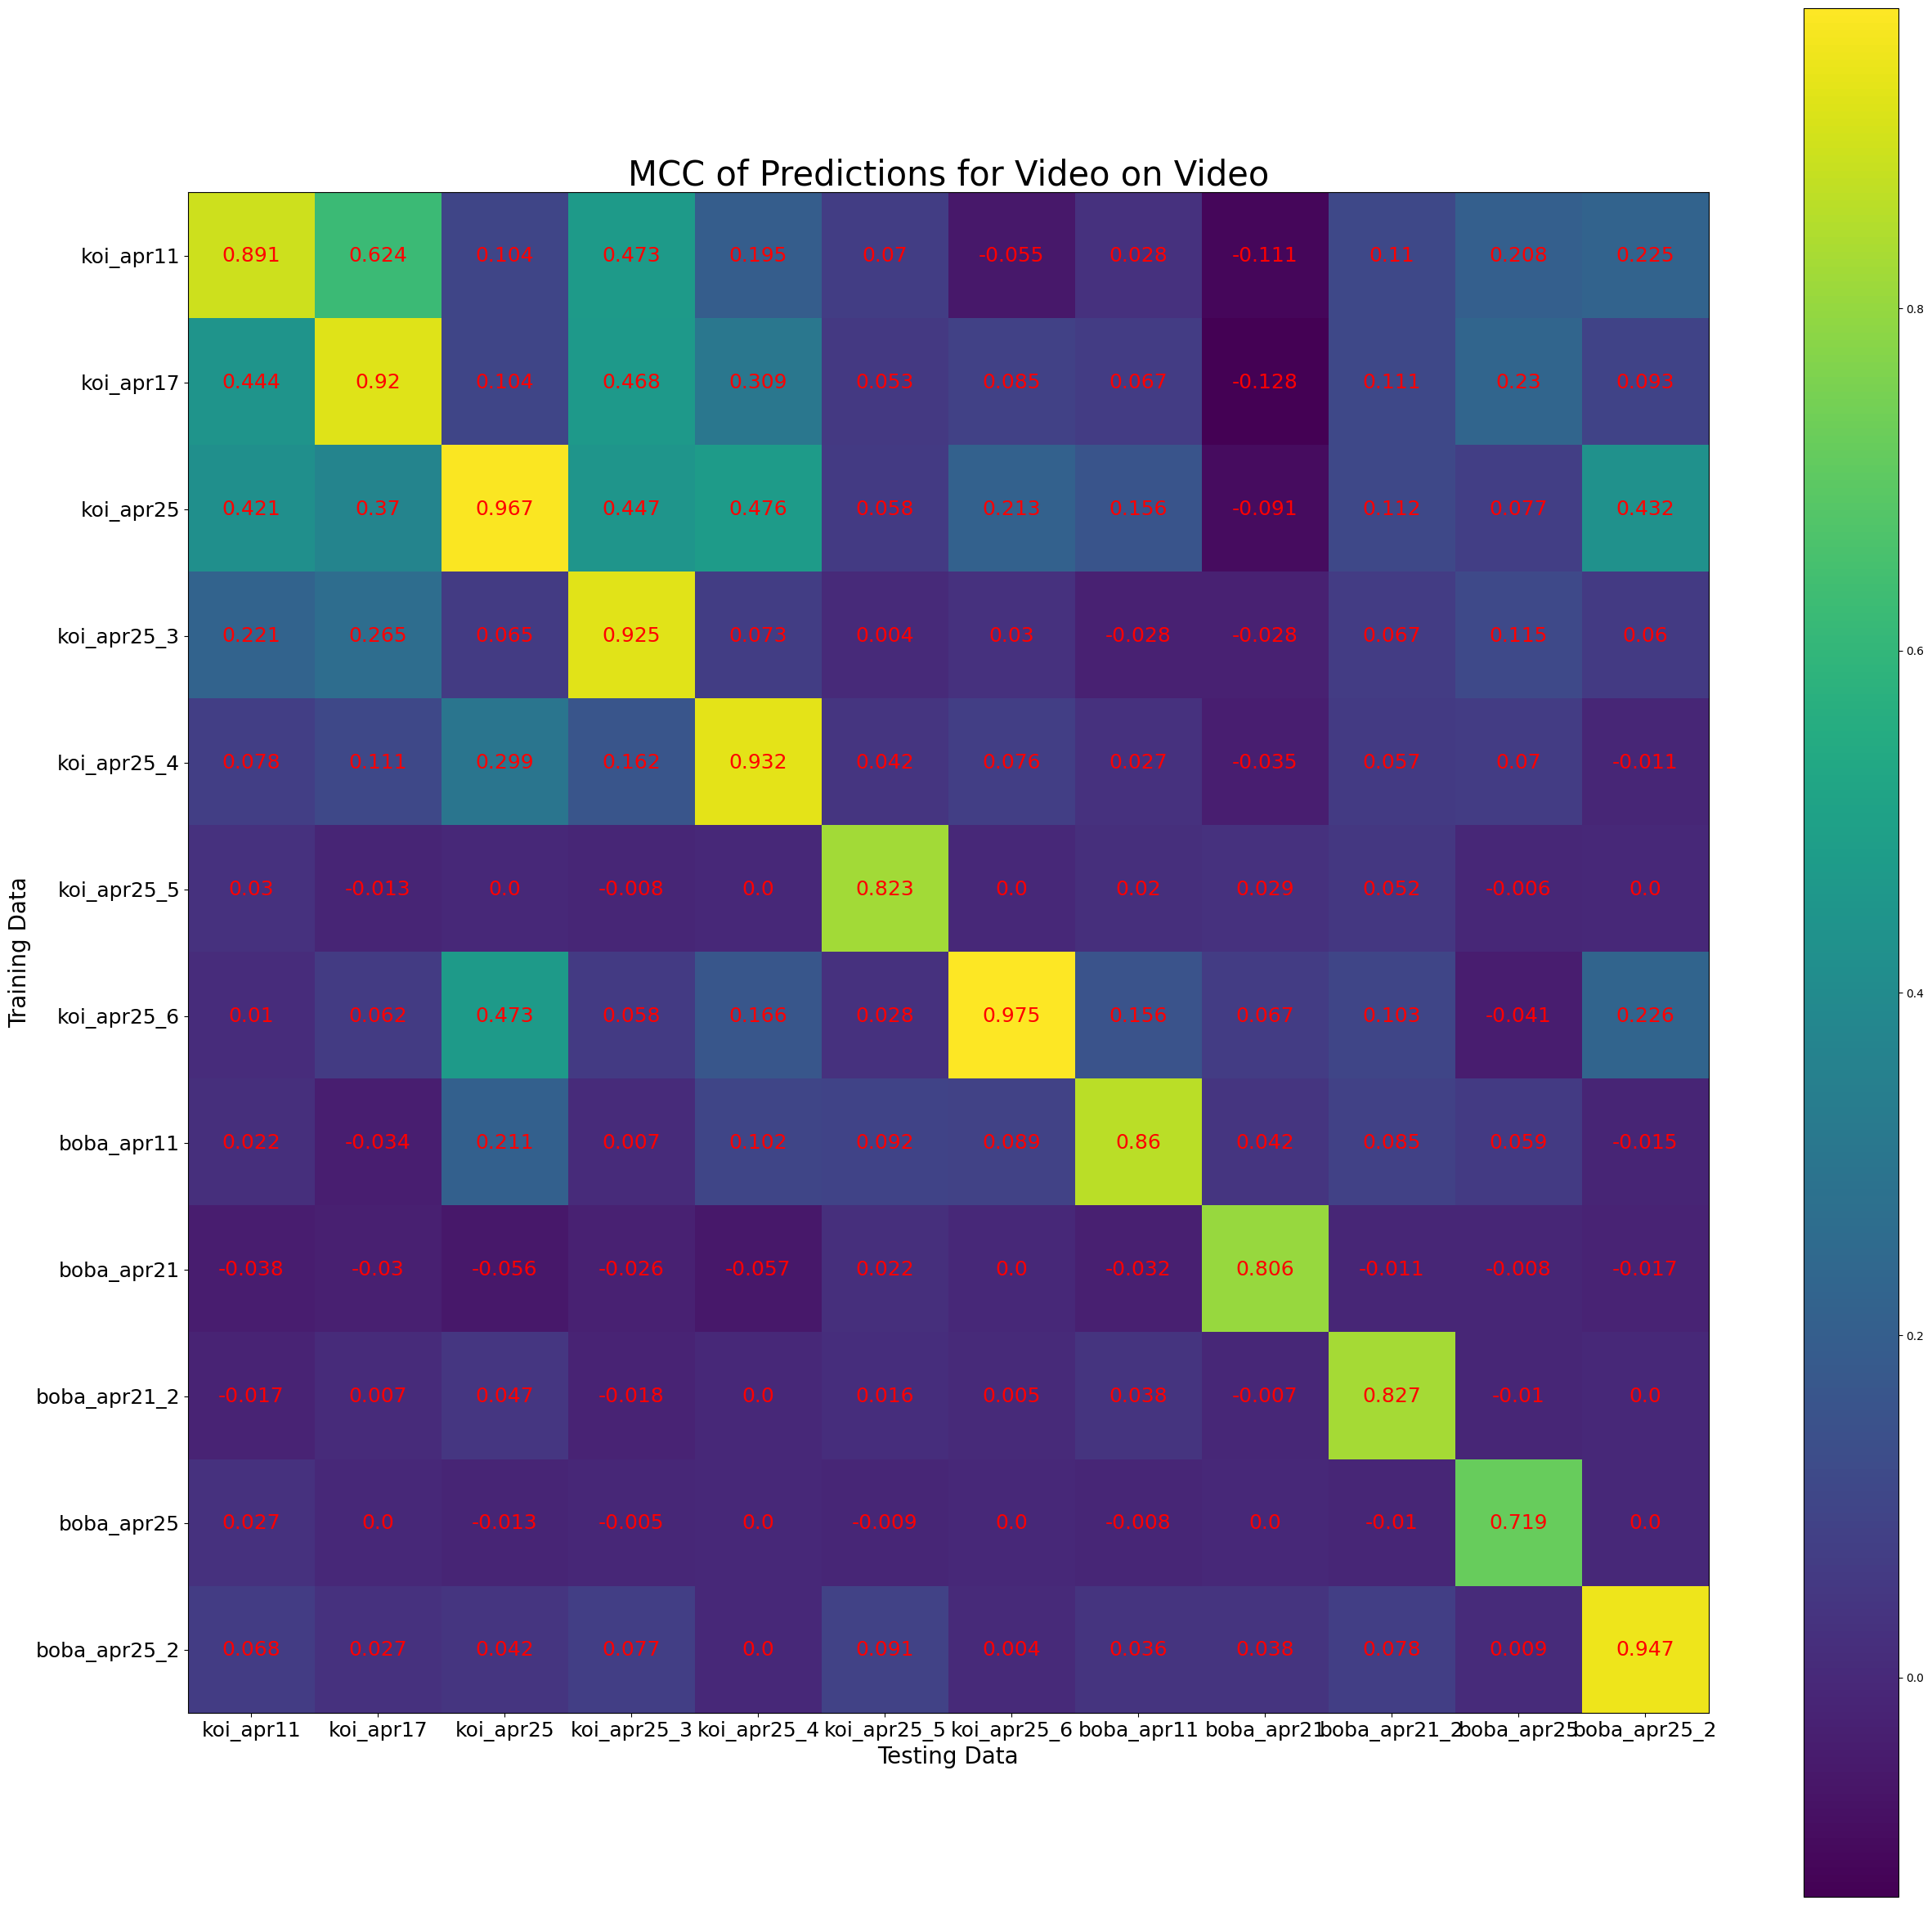

In [44]:
visualise_6a = []

for train_name in results_6a:
    train_row = []
    for test_name in results_6a[train_name]:
        train_row.append(results_6a[train_name][test_name]["mcc"])
    visualise_6a.append(train_row)

plt.imshow(visualise_6a)

plt.title("MCC of Predictions for Video on Video", size=30)
plt.xlabel("Testing Data", size=20)
plt.ylabel("Training Data", size=20)
plt.xticks(range(len(names_all)), names_all, size=18)
plt.yticks(range(len(names_all)), names_all, size=18)

for r in range(len(visualise_6a)):
    for c in range(len(visualise_6a[r])):
        plt.text(c, r, round(visualise_6a[r][c], 3), ha='center', va='center', color="red", size=18)

plt.colorbar()
plt.gcf().set_size_inches(30, 30)
plt.show()

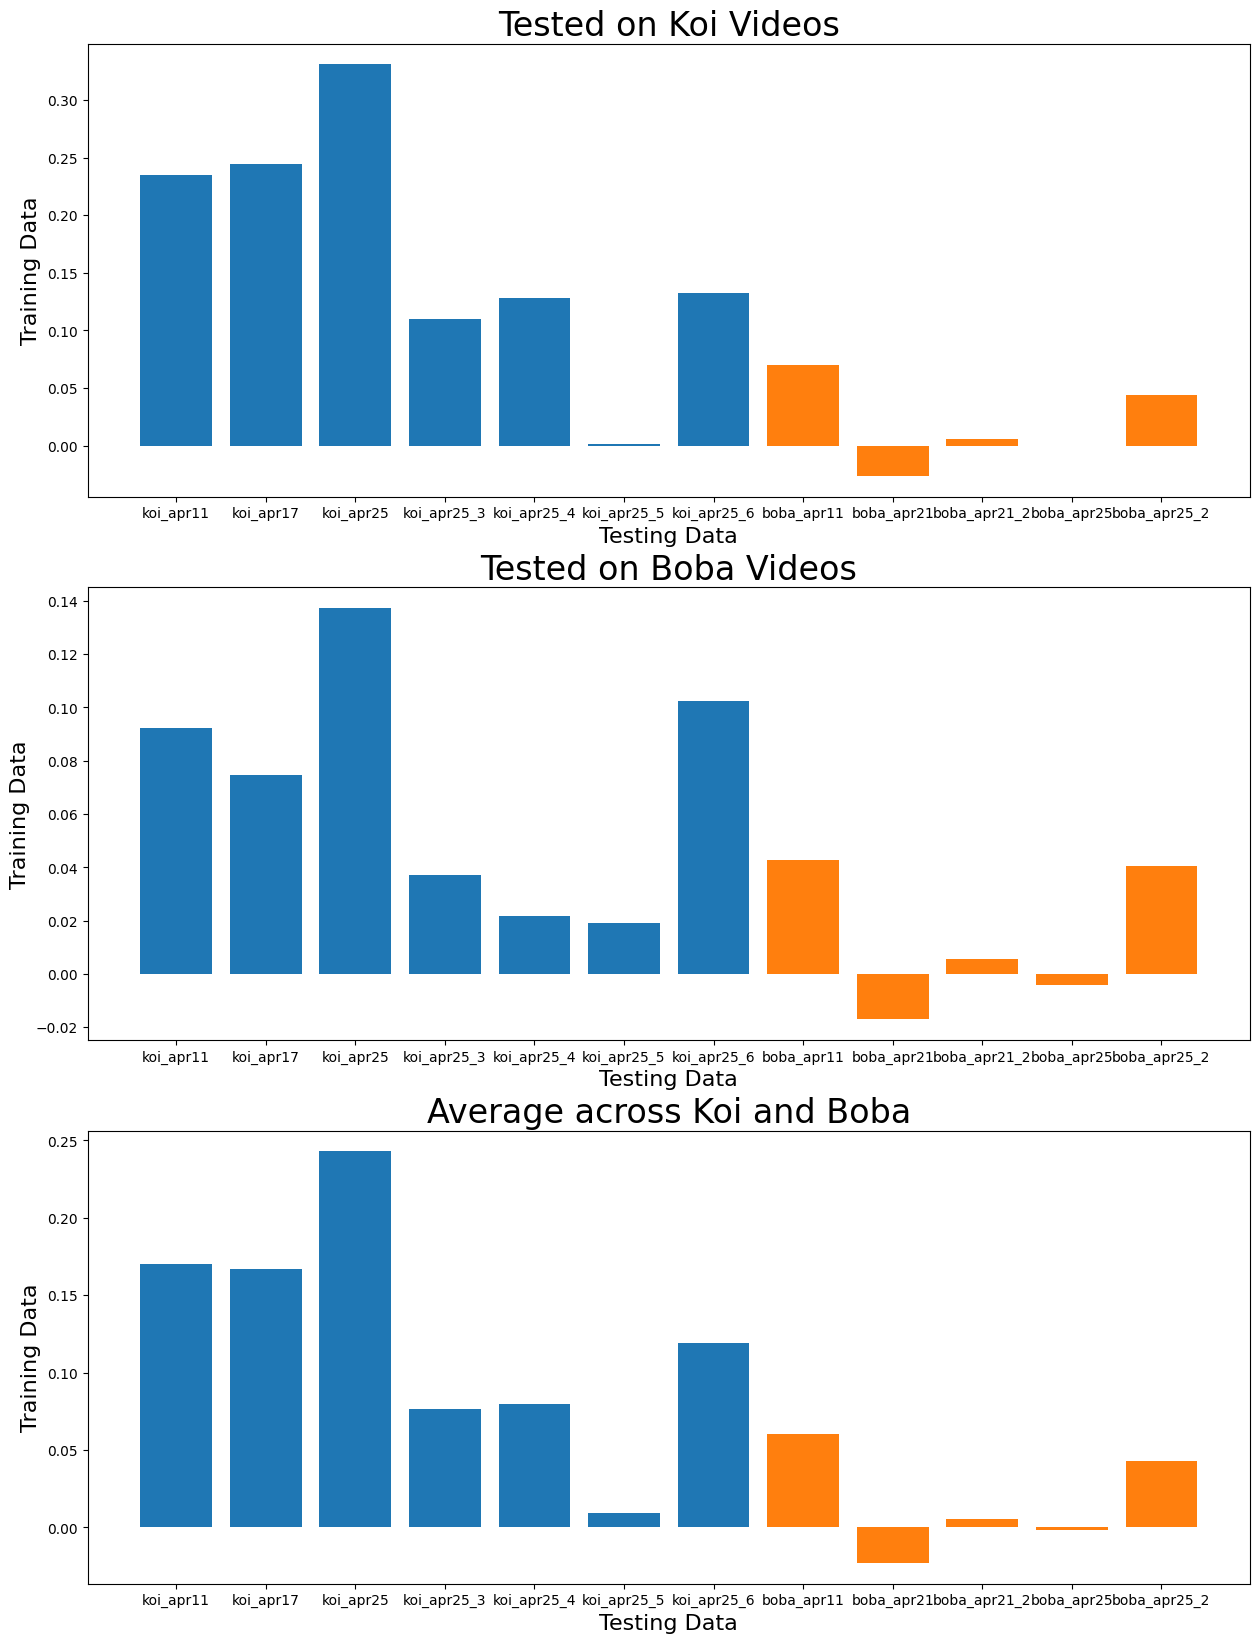

In [16]:
bar_koi_6a = [np.mean([results_6a[train_name][test_name]["mcc"] for test_name in results_6a[train_name] if (test_name is not train_name) and ("koi" in test_name)]) for train_name in results_6a]
bar_boba_6a = [np.mean([results_6a[train_name][test_name]["mcc"] for test_name in results_6a[train_name] if (test_name is not train_name) and ("boba" in test_name)]) for train_name in results_6a]
bar_mean_6a = [np.mean([results_6a[train_name][test_name]["mcc"] for test_name in results_6a[train_name] if (test_name is not train_name)]) for train_name in results_6a]

fig, ax = plt.subplots(nrows=3, ncols=1)

plt.title("Average MCC of Predictions when Trained on Single Video Data")

ax[0].bar(names_all, bar_koi_6a, color=["tab:blue" if "koi" in name else "tab:orange" for name in names_all])
ax[0].set_title("Tested on Koi Videos",size=24)
ax[0].set_xlabel("Testing Data", size=16)
ax[0].set_ylabel("Training Data", size=16)

ax[1].bar(names_all, bar_boba_6a, color=["tab:blue" if "koi" in name else "tab:orange" for name in names_all])
ax[1].set_title("Tested on Boba Videos",size=24)
ax[1].set_xlabel("Testing Data", size=16)
ax[1].set_ylabel("Training Data", size=16)

ax[2].bar(names_all, bar_mean_6a, color=["tab:blue" if "koi" in name else "tab:orange" for name in names_all])
ax[2].set_title("Average across Koi and Boba",size=24)
ax[2].set_xlabel("Testing Data", size=16)
ax[2].set_ylabel("Training Data", size=16)

plt.gcf().set_size_inches(15, 20)
plt.show()

## Test 6B: How Many Videos?

**Aim**: Check how the number of videos used in training affects predictions.

**Feature Tested**: Directional Change

**Noise Correction**: 0.1 threshold and 10 sliding window

**Weights**: None

**Class Balance**: Balanced

### Datasets Info

#### All Sets
_Testing Data_
* Koi, April 11 (20%)
* Boba, April 11 (20%)

#### Individual Set 1
_Koi Training Data_
* Koi, April 17 (80%)

_Boba Training Data_
* Boba, April 21 (80%)

#### Individual Set 2
_Koi Training Data_
* Koi, April 17 (80%)
* Koi, April 25 (5) (80%)

_Boba Training Data_
* Boba, April 21 (80%)
* Boba, April 25 (80%)

#### Individual Set 3
_Koi Training Data_
* Koi, April 17 (80%)
* Koi, April 25 (5) (80%)
* Koi, April 25 (80%)
* Koi, April 25 (4) (80%)
* Koi, April 25 (6) (80%)

_Boba Training Data_
* Boba, April 21 (80%)
* Boba, April 25 (80%)
* Boba, April 21 (2) (80%)
* Boba, April 25 (2) (80%)

#### Mixed Set 1
_Training Data_
* Koi, April 17 (80%)
* Boba, April 21 (80%)

#### Mixed Set 2
_Training Data_
* Koi, April 17 (80%)
* Koi, April 25 (5) (80%)
* Boba, April 21 (80%)
* Boba, April 25 (80%)

#### Mixed Set 3
_Training Data_
* Koi, April 17 (80%)
* Koi, April 25 (5) (80%)
* Koi, April 25 (80%)
* Koi, April 25 (4) (80%)
* Koi, April 25 (6) (80%)
* Boba, April 21 (80%)
* Boba, April 25 (80%)
* Boba, April 21 (2) (80%)
* Boba, April 25 (2) (80%)

### Actual Code

In [22]:
process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)

processed_data, processed_labels = process_data(pose_data_all, labels_all, process)
training_data, testing_data, training_labels, testing_labels = prep_multi_train_test_data(processed_data, processed_labels, names_all)

In [40]:
training_names = {}

training_names["koi"] = []
training_names["koi"].append(["koi_apr17"])
training_names["koi"].append(["koi_apr17", "koi_apr25_3"])
training_names["koi"].append(["koi_apr17", "koi_apr25_3", "koi_apr25", "koi_apr25_4", "koi_apr25_6"])

training_names["boba"] = []
training_names["boba"].append(["boba_apr21"])
training_names["boba"].append(["boba_apr21", "boba_apr25"])
training_names["boba"].append(["boba_apr21", "boba_apr25", "boba_apr21_2", "boba_apr25_2"])

training_names["mixed"] = []
for i in range(3):
    training_names["mixed"].append(training_names["koi"][i] + training_names["boba"][i])

test_koi_data_6b = testing_data["koi_apr11"]
test_koi_labels_6b = testing_labels["koi_apr11"]

test_boba_data_6b = testing_data["boba_apr11"]
test_boba_labels_6b = testing_labels["boba_apr11"]

results_6b = {}
results_6b["koi"] = {"individual":[], "mixed":[]}
results_6b["boba"] = {"individual":[], "mixed":[]}

In [41]:
clf = RandomForestClassifier(class_weight='balanced')

for name in training_names:
    sets = training_names[name]

    for set_names in sets:
        set_td = np.concatenate([training_data[x] for x in training_data if x in set_names])
        set_tl = np.concatenate([training_labels[y] for y in training_labels if y in set_names])

        clf.fit(set_td, set_tl)
        
        if "koi" == name:
            results_6b[name]["individual"].append(test_classify(clf, test_koi_data_6b, test_koi_labels_6b))
        elif "boba" == name:
            results_6b[name]["individual"].append(test_classify(clf, test_boba_data_6b, test_boba_labels_6b))
        else:
            results_6b["koi"]["mixed"].append(test_classify(clf, test_koi_data_6b, test_koi_labels_6b))
            results_6b["boba"]["mixed"].append(test_classify(clf, test_boba_data_6b, test_boba_labels_6b))

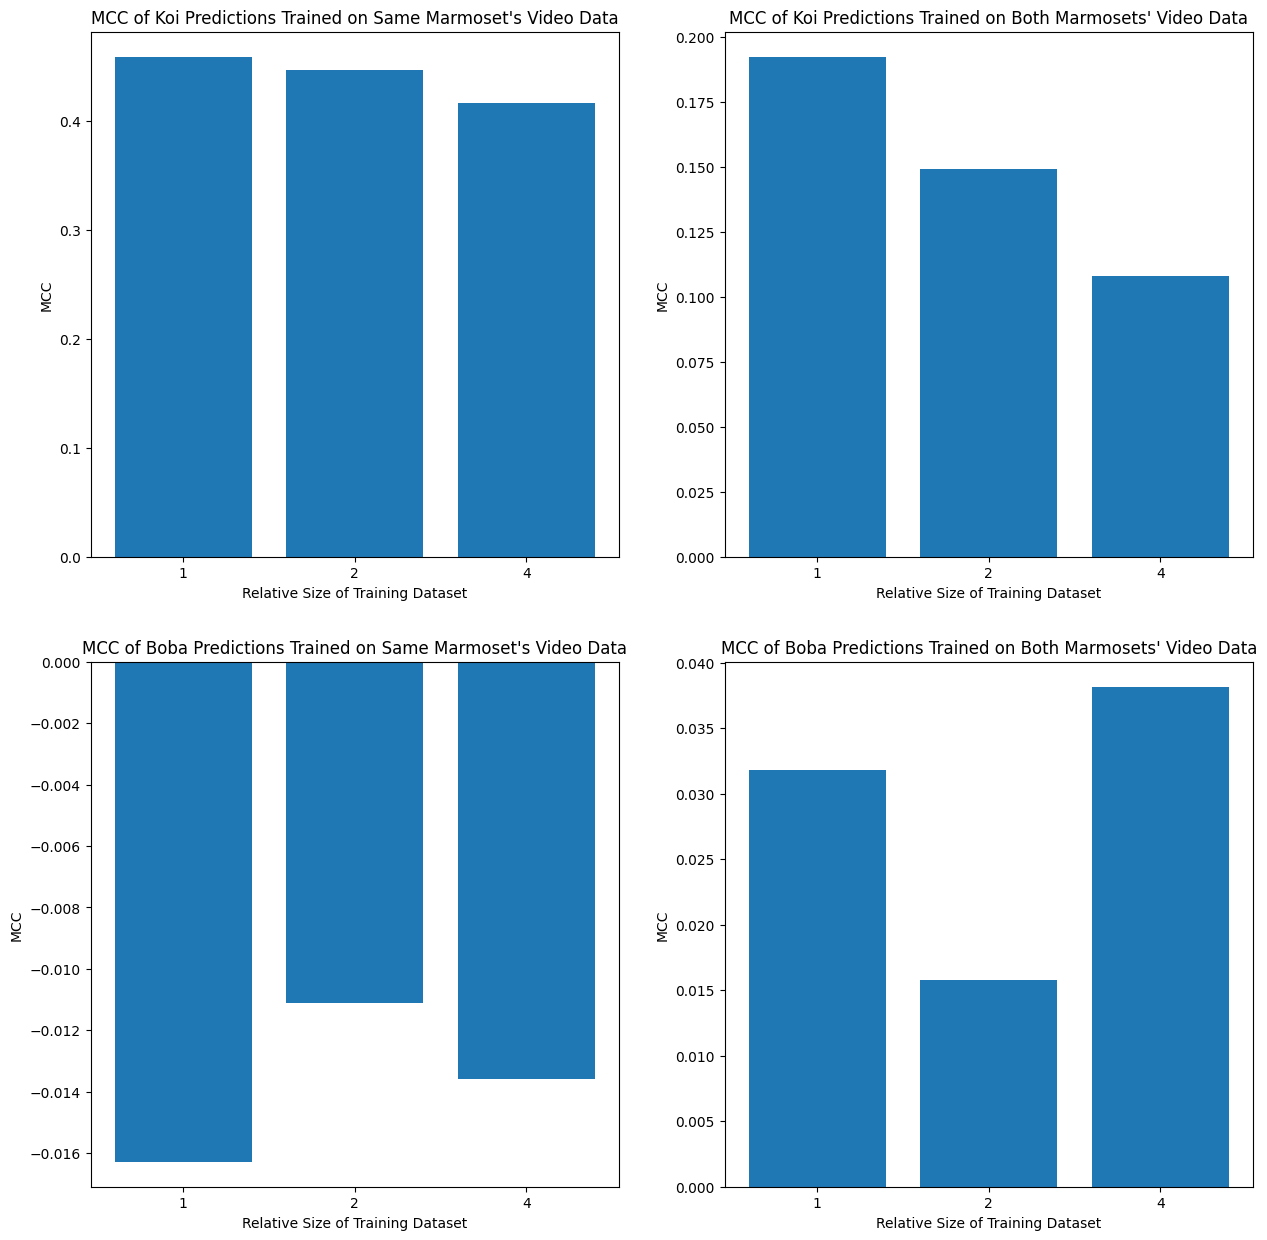

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2)
axes = ax.reshape(-1)
xy = 0
x_tick_labels = ["1", "2", "4"]

stype = lambda s : "Same Marmoset's" if s == "individual" else "Both Marmosets'"

for test_name in results_6b:
    for test_type in results_6b[test_name]:
        visualise_6b = [i["mcc"] for i in results_6b[test_name][test_type]]
        axes[xy].bar(x_tick_labels, visualise_6b)
        axes[xy].set_title(f'MCC of {test_name.capitalize()} Predictions Trained on {stype(test_type)} Video Data')
        axes[xy].set_xlabel("Relative Size of Training Dataset")
        axes[xy].set_xticks(x_tick_labels, x_tick_labels)
        axes[xy].set_ylabel("MCC")
        xy += 1

fig.set_size_inches(15, 15)

## Test 6C: How Many Videos? Part 2

**Aim**: Test how increasing relative size of training data affects the variation of MCC when performing prediction on test data.

**Feature Tested**: Directional Change

**Noise Correction**: 0.1 threshold and 10 sliding window

**Weights**: None

**Class Balance**: Balanced

### Datasets Information

The trends in MCC with relative size of training data differ across the test video used and the training data used. There is no clear pattern. Instead of MCC itself, let us examine if variation in MCC decreases with size of training data.

**All Sets**

_Testing Data_
* Koi, April 25 (4)
* Koi, April 25 (6)

**Set 1**

_Training Data_ (4 combinations)
* Koi, April 11
* Koi, April 17
* Koi, April 25
* Koi, April 25 (3)

**Set 2**

_Training Data_ (6 combinations)
* Koi, April 11 + Koi, April 17
* Koi, April 11 + Koi, April 25
* Koi, April 11 + Koi, April 25 (3)
* Koi, April 17 + Koi, April 25
* Koi, April 17 + Koi, April 25 (3)
* Koi, April 25 + Koi, April 25 (3)

**Set 3**

_Training Data_ (4 combinations)
* Koi, April 11 + Koi, April 17 + Koi, April 25
* Koi, April 11 + Koi, April 17 + Koi, April 25 (3)
* Koi, April 17 + Koi, April 25 + Koi, April 25 (3)
* Koi, April 25 + Koi, April 25 (3) + Koi, April 11

**Set 4**

_Training Data_ (1 combination)
* Koi, April 11 + Koi, April 17 + Koi, April 25 + Koi, April 25 (3)

### Actual Code

In [50]:
test_names_6c = ["koi_apr25_4", "koi_apr25_6"]
train_names_6c = ["koi_apr11", "koi_apr17", "koi_apr25", "koi_apr25_3"]

process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)
data_6c, labels_6c = mc.process_data(pose_data_koi, labels_koi, process)

runs = [3, 2, 3, 12]
clf = RandomForestClassifier(class_weight="balanced_subsample")

In [70]:
results_6c = []

for i in range(1,5):
    combos = itertools.combinations(train_names_6c, i)

    results_6c.append({})

    for train_combo in combos:
        results_6c[i-1][train_combo] = []
        for _ in range(runs[i-1]):
            training_data, test_data, training_labels, test_labels = mc.prep_train_test_data(data_6c, labels_6c, train_combo, test_names=test_names_6c)
            clf.fit(training_data, training_labels)
            results_6c[i-1][train_combo].append(mc.test_classify(clf, np.concatenate([test_data[n] for n in test_data]), np.concatenate([test_labels[m] for m in test_labels])))

In [87]:
mccs_6c = []
set_size = 1

for set in results_6c:
    mccs_6c.append([])
    for combo in set:
        for trial in set[combo]:
            mccs_6c[set_size - 1].append(trial["mcc"])
    set_size += 1

avg_mcc_6c = np.mean(mccs_6c, axis=1)
variance_6c = np.var(mccs_6c, axis=1)

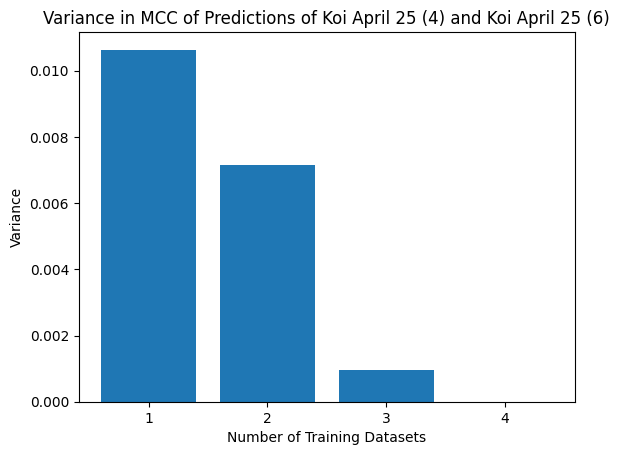

In [90]:
xticks = list(range(1, len(variance_6c)+1))
plt.bar(xticks, variance_6c)
plt.title("Variance in MCC of Predictions of Koi April 25 (4) and Koi April 25 (6)")
plt.xlabel("Number of Training Datasets")
plt.ylabel("Variance")
plt.xticks(xticks)
plt.show()

In [91]:
variance_6c

array([1.06363838e-02, 7.15080703e-03, 9.58784267e-04, 2.94980817e-06])

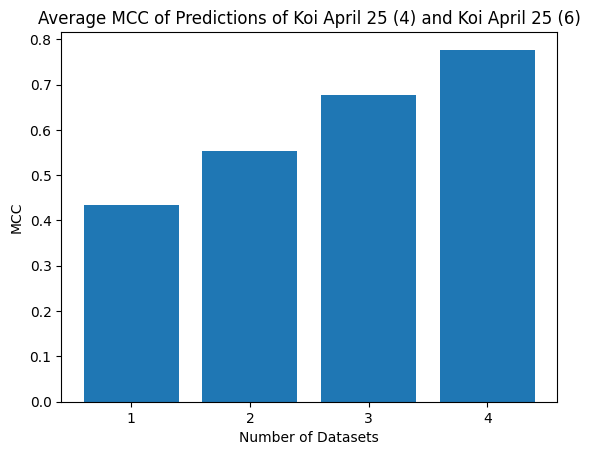

In [89]:
plt.bar(xticks, avg_mcc_6c)
plt.title("Average MCC of Predictions of Koi April 25 (4) and Koi April 25 (6)")
plt.xlabel("Number of Training Datasets")
plt.ylabel("MCC")
plt.xticks(xticks)
plt.show()

## Test 6D: Which Feature is Best?

**Aim**: Test which feature, when extracted from the data sets, leads to the best predictions.

**Feature Tested**: Directional Change

**Noise Correction**: 0.1 threshold and 10 sliding window

**Weights**: None

**Class Balance**: Balanced

### Datasets Information

_Training Data_
* All Koi videos except Koi, April 25 (5) (80%)

_Testing Data_
* All Koi videos except Koi, April 25 (5) (20%)

### Actual Code

In [5]:
joints = [(5, 7, 9), (6, 8, 10), (7, 5, 6), (8, 6, 5),
          (11, 13, 15), (12, 14, 16), (13, 11, 12), (14, 12, 11)]

features = {"dir_change": lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1),
            "3d_angle": lambda x : mf.changes_in_changes_in_phi_theta(x, 10, 0.1),
            "joint_angle":lambda x : mf.changes_in_changes(mf.change_in_joint_angle(joints)(x), 10, 0.1)}

In [65]:
train_names_6d = ["koi_apr11", "koi_apr17", "koi_apr25", "koi_apr25_3", "koi_apr25_4", "koi_apr25_6"]
results_6d = {}

clf = RandomForestClassifier(class_weight="balanced")

for feature_name in features:
    process = features[feature_name]
    processed_data, processed_labels = process_data(pose_data_koi, labels_koi, process)

    training_data, testing_data, training_labels, testing_labels = prep_train_test_data(processed_data, processed_labels, train_names_6d)
    clf.fit(training_data, training_labels)
    results_6d[feature_name] = test_classify(clf, np.concatenate((testing_data["koi_apr25_4"], testing_data["koi_apr25_6"])), np.concatenate((testing_labels["koi_apr25_4"], testing_labels["koi_apr25_6"])))

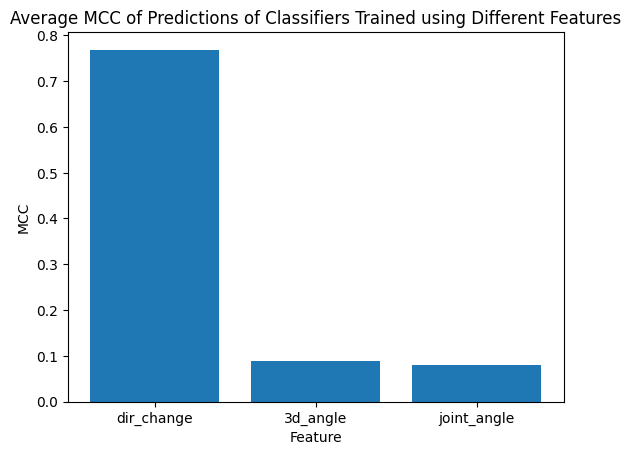

In [66]:
bar_heights_6d = [results_6d[feature_name]["mcc"] for feature_name in features]

plt.bar(features.keys(), bar_heights_6d)
plt.title("Average MCC of Predictions of Classifiers Trained using Different Features")
plt.xlabel("Feature")
plt.ylabel("MCC")
plt.show()